In [1]:
# Imports
from shapely.ops import nearest_points
import geopandas as gpd
import pyproj
from shapely.geometry import Polygon, LineString, Point, MultiPolygon, MultiLineString
from shapely.ops import transform, polygonize, unary_union
from scipy.optimize import fminbound, minimize
import matplotlib.pyplot as plt
from pyproj import Geod
import math
import numpy as np
import json
import pandas as pd
import osmnx as ox
import networkx as nx

In [2]:
# DEFINE USEFUL FUNCTIONS

def get_utm_zone(lon):
    print(lon)
    return int((lon + 180) // 6) + 1

def get_utm_proj(lon, lat):
    print(lon)
    utm_zone = get_utm_zone(lon)
    is_northern = lat >= 0  # Determine if the zone is in the northern hemisphere
    return f"+proj=utm +zone={utm_zone} +{'north' if is_northern else 'south'} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

# Simplified function to convert a distance in degrees to meters
def degrees_to_meters(distance_in_degrees, utm_proj_rectangle):
    
    # Create transformers for a small unit distance in degrees (1 degree) to meters
    transformer = pyproj.Transformer.from_crs("EPSG:4326", utm_proj_rectangle, always_xy=True)
    
    # Convert 1 degree distance to meters (latitude = 0 -- assume small distance near the UTM zone)
    lon1, lat1 = 0, 0
    lon2, lat2 = 1, 0
    
    x1, y1 = transformer.transform(lon1, lat1)
    x2, y2 = transformer.transform(lon2, lat2)
    
    # Calculate the distance in meters for 1 degree of longitude
    meters_per_degree = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    
    # Convert the input distance in degrees to meters
    distance_in_meters = distance_in_degrees * meters_per_degree
    
    return distance_in_meters

def calculate_area_geodesic(rectangle):
    # Create a Geod object for geodesic calculations
    geod = Geod(ellps="WGS84")

    # Calculate the area using the geod object. The area is returned in square meters.
    try: 
        area, _ = geod.geometry_area_perimeter(rectangle.geometry[0])
    except (KeyError, RecursionError):
        area, _ = geod.geometry_area_perimeter(rectangle.geometry)

    return abs(area)

In [3]:
# Read needed files: rectangle, buildings, streets

tile_id = 16
rectangles = gpd.read_file('./data/rectangles.geojson')
rectangle = rectangles[rectangles.n==tile_id]
try:
    rectangle_centroid = rectangle.geometry[0].centroid
except KeyError:
    rectangle_centroid = rectangle.geometry.centroid
utm_proj_rectangle = get_utm_proj(float(rectangle_centroid.x),float(rectangle_centroid.y))
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), utm_proj_rectangle, always_xy=True).transform


OSM_buildings = gpd.read_file(f"./output_data/OSM_buildings_{tile_id}.gpkg")
OSM_roads = gpd.read_file(f"./output_data/OSM_roads_{tile_id}.gpkg")
OSM_intersections = gpd.read_file(f"./output_data/OSM_intersections_{tile_id}.gpkg").to_crs(utm_proj_rectangle)

Overture_data = gpd.read_file(f"./output_data/Overture_building_{tile_id}.geojson").to_crs(utm_proj_rectangle)#.clip(rectangle['geometry'])
Overture_data['confidence'] = Overture_data.sources.apply(lambda x: json.loads(x)[0]['confidence'])
Overture_data['dataset'] = Overture_data.sources.apply(lambda x: json.loads(x)[0]['dataset'])



buildings_OSM = OSM_buildings[(OSM_buildings.building=='yes')].to_crs(utm_proj_rectangle)
Overture_data = Overture_data.set_geometry('geometry')[Overture_data.dataset!='OpenStreetMap']
buildings_OSM = buildings_OSM.set_geometry('geometry')
buildings = gpd.GeoDataFrame(pd.concat([buildings_OSM, Overture_data], axis=0, ignore_index=True, join='outer')).drop_duplicates('geometry').to_crs(utm_proj_rectangle)

roads = OSM_roads.to_crs(utm_proj_rectangle)
road_union = roads.to_crs(utm_proj_rectangle).unary_union # Create a unary union of the road geometries to simplify distance calculation


27.568471957527002
27.568471957527002


/var/folders/mt/3n9j2kc92kv4psztx687vtd80000gn/T/ipykernel_17443/3703104580.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rectangle_centroid = rectangle.geometry.centroid
/var/folders/mt/3n9j2kc92kv4psztx687vtd80000gn/T/ipykernel_17443/3703104580.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  utm_proj_rectangle = get_utm_proj(float(rectangle_centroid.x),float(rectangle_centroid.y))


In [4]:
# Function to calculate the shortest distance to roads
def calculate_minimum_distance_to_roads(building, road_union,utm_proj_rectangle):
    nearest_geom = nearest_points(building, road_union)[1] #distance to closest road, given the input order
    return building.distance(nearest_geom)


In [5]:
# Function to calculate the angle between two vectors
def calculate_angle(vector1, vector2):
    angle = np.arctan2(vector2[1], vector2[0]) - np.arctan2(vector1[1], vector1[0])
    angle = np.degrees(angle)
    if angle < 0:
        angle += 360
    return angle

def calculate_sequential_angles(intersections, roads):
    records = []  # List to store angle records
    
    # Iterate through each intersection
    for _, intersection in intersections.iterrows():
        intersection_id = intersection['osmid']
        intersection_point = intersection.geometry
        
        # Get all roads connected to the intersection
        connected_roads = roads[(roads['u'] == intersection_id) | (roads['v'] == intersection_id)]
        vectors = []
        
        for _, road in connected_roads.iterrows():
            coords = list(road.geometry.coords)
            
            # Determine the vector for the road segment away from the intersection
            if road['u'] == intersection_id:
                vector = (coords[1][0] - coords[0][0], coords[1][1] - coords[0][1])
            else:
                vector = (coords[-2][0] - coords[-1][0], coords[-2][1] - coords[-1][1])
            
            vectors.append((vector, road['u'], road['v']))
        
        # Sort vectors based on the angle relative to a fixed axis (e.g., x-axis)
        vectors.sort(key=lambda v: np.arctan2(v[0][1], v[0][0]))

        # Calculate the sequential angles between each pair of vectors
        for i in range(len(vectors)):
            vector1 = vectors[i][0]
            vector2 = vectors[(i + 1) % len(vectors)][0]  # Next vector, looping back to the start
            angle = calculate_angle(vector1, vector2)
            
            record = {
                'Intersection ID': intersection_id,
                'Segment 1': (vectors[i][1], vectors[i][2]),
                'Segment 2': (vectors[(i + 1) % len(vectors)][1], vectors[(i + 1) % len(vectors)][2]),
                'Angle': angle
            }
            records.append(record)
    
    # Create a DataFrame from the records
    df_angles = pd.DataFrame(records)
    
    return df_angles

In [6]:

# Block polygons

def get_blocks(road_union, roads):
    # Use polygonize to create polygons from the merged lines
    blocks = list(polygonize(road_union))
    blocks_gdf = gpd.GeoDataFrame(geometry=blocks, crs=roads.crs)
    # Filter out very small polygons if necessary
    blocks_gdf = blocks_gdf[blocks_gdf.area > 9]
    blocks_gdf['area'] = blocks_gdf.area
    #blocks_gdf.to_file("blocks_tile1.gpkg", driver="GPKG")
    return blocks_gdf.sort_values('area')

blocks = get_blocks(road_union, roads)

<Axes: >

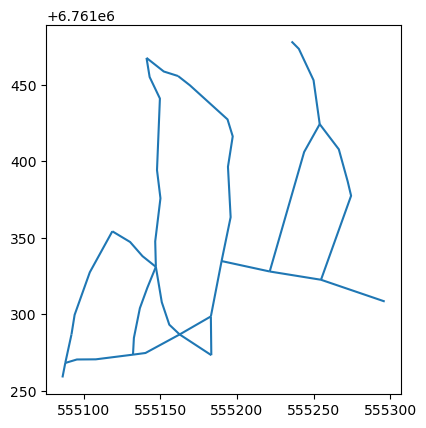

In [7]:
roads.plot()

In [8]:
# Building orientation

def longest_segment(polygon):
    # Ensure the input is a valid Polygon
    if not isinstance(polygon, Polygon):
        raise TypeError("The input must be a shapely Polygon object.")
    
    # Get the exterior coordinates of the polygon
    exterior_coords = polygon.exterior.coords
    
    # Initialize variables to track the longest segment
    max_length = 0
    longest_segment = None
    
    # Iterate through the exterior coordinates to find the longest segment
    for i in range(len(exterior_coords) - 1):
        # Create a line segment from consecutive coordinates
        segment = LineString([exterior_coords[i], exterior_coords[i+1]])
        
        # Calculate the length of the segment
        segment_length = segment.length
        
        # Update the longest segment if this one is longer
        if segment_length > max_length:
            max_length = segment_length
            longest_segment = segment
    
    return longest_segment

def calculate_azimuth(segment):
    # Extract start and end points of the segment
    start_point = segment.coords[0]
    end_point = segment.coords[1]
    
    # Calculate the difference in coordinates
    delta_x = end_point[0] - start_point[0]
    delta_y = end_point[1] - start_point[1]
    
    # Calculate the azimuth in radians
    azimuth_rad = math.atan2(delta_x, delta_y)
    
    # Convert the azimuth to degrees
    azimuth_deg = math.degrees(azimuth_rad)
    
    # Normalize the azimuth to be within 0 to 360 degrees
    azimuth_deg = (azimuth_deg + 360) % 360
    
    return np.abs(azimuth_deg)


In [9]:
# Get largest circle inscribed in block

def get_largest_inscribed_circle(block):
    polygon = block
    # Initial guess: the centroid of the polygon
    centroid = polygon.geometry.centroid
    initial_guess = [centroid.x, centroid.y]

    # Calculate negative radius to maximize
    def negative_radius(point_coords):
        point = Point(point_coords)

        if polygon.geometry.contains(point):
            return -polygon.geometry.boundary.distance(point)
        else:
            return np.inf  # Outside the polygon, so invalid

    # Optimization to find the largest inscribed circle
    result = minimize(negative_radius, initial_guess, method='Nelder-Mead')

    # Get the maximum inscribed circle
    optimal_point = Point(result.x)
    max_radius = -result.fun  # Negative of the minimized value

    #print(f"Largest circle center: {optimal_point}")
    #print(f"Maximum radius: {max_radius}")
    return optimal_point, max_radius

In [10]:
def objective_function(radius, block, target_area):
    """
    Objective function to minimize the difference between the internal buffer area and the target area.
    
    :param radius: The buffer radius to be optimized.
    :param block: The input polygon geometry.
    :param target_area: The desired area for the internal buffer.
    :return: The absolute difference between the current area and the target area.
    """
    internal_buffer = block.geometry.difference(block.geometry.buffer(-radius))
    
    # Handle cases where the result is empty or not a valid polygon
    if internal_buffer.is_empty or not isinstance(internal_buffer, (Polygon, MultiPolygon)):
        return float('inf')
    
    buffer_area = internal_buffer.area
    return abs(buffer_area - target_area)

def get_internal_buffer_with_target_area(block, target_area, tolerance=1e-6):
    """
    Finds the buffer radius that results in an internal buffer with an area close to the target area.
    
    :param block: The input polygon geometry.
    :param target_area: The desired area for the internal buffer.
    :param tolerance: The tolerance within which the area should match the target.
    :return: The internal buffer polygon with an area close to the target area.
    """
    # Get the largest inscribed circle's radius for the upper bound
    _, max_radius = get_largest_inscribed_circle(block)
    
    # Use fminbound to find the radius that minimizes the area difference
    optimal_radius = fminbound(objective_function, 0, max_radius, args=(block, target_area), xtol=tolerance)
    
    # Compute the internal buffer with the optimal radius
    internal_buffer = block.geometry.difference(block.geometry.buffer(-optimal_radius))
    
    return internal_buffer



In [11]:
# Inflection points
def get_inflection_points(roads,threshold):
    inflection_gdf = gpd.GeoDataFrame({'geometry':[],'angle':[]})
    inflection_list = []
    for row in roads.iterfeatures():
        line = row['geometry']
        inflection_points = []
        angles = []
        coords = list(line['coordinates'])
        for i in range(1, len(coords) - 1):
            p1 = np.array(coords[i - 1])
            p2 = np.array(coords[i])
            p3 = np.array(coords[i + 1])

            # Calculate angle between the segments
            v1 = p2 - p1
            v2 = p3 - p2

            angle1 = np.arctan2(v1[1], v1[0])
            angle2 = np.arctan2(v2[1], v2[0])

            # Calculate the difference and convert to degrees
            angle_diff = np.degrees(np.abs(angle2 - angle1))
            angle_diff = np.mod(angle_diff, 360)

            # Normalize the angle difference to [0, 180] degrees
            if angle_diff > 180:
                angle_diff = 360 - angle_diff

            # Store significant changes (e.g., greater than 10 degrees)
            if angle_diff > threshold:  
                inflection_points.append(Point(p2))
                angles.append(angle_diff)

        inflection_dict = gpd.GeoDataFrame({
            'geometry': inflection_points,
            'angle': angles
        })
        if len(inflection_points)>0:
            inflection_gdf = pd.concat([inflection_gdf,inflection_dict])
    return inflection_gdf


In [12]:
#1 Share of building footprints that are less than 10-meters away from the nearest road

def metric_1_distance_less_than_10m(buildings):
    # Apply the distance calculation to each building
    buildings.loc[:,'distance_to_road'] = buildings['geometry'].apply(lambda x: x.centroid).apply(calculate_minimum_distance_to_roads, 
                                                                                                  road_union = road_union, 
                                                                                                  utm_proj_rectangle = utm_proj_rectangle)
    return 100.*((sum(buildings['distance_to_road']<=10))/len(buildings))

metric_1_distance_less_than_10m(buildings)

26.126126126126124

In [13]:
#2 Average distance of building footprint centroids to roads
# THIS FUNCTION CAN ONLY BE CALLED AFTER metric_1
def metric_2_average_distance_to_roads(buildings):
    return buildings['distance_to_road'].mean()
metric_2_average_distance_to_roads(buildings)

27.75329840779199

In [14]:
rectangle_area = calculate_area_geodesic(rectangle)


RecursionError: maximum recursion depth exceeded

In [ ]:
#3 Density of roads
def metric_3_road_density(roads,rectangle):
    try:
        rectangle_projected = transform(project, rectangle.geometry[0])
    except KeyError:
        rectangle_projected = transform(project, rectangle.geometry.values[0])
    roads_rectangle = roads.clip(rectangle_projected)
    km_length = roads_rectangle.length.sum()/1000.
    rectangle_area = calculate_area_geodesic(rectangle)
    rectangle_area_km2 = rectangle_area/1000000.
    return km_length/rectangle_area_km2

metric_3_road_density(roads,rectangle)

In [15]:
#4 Share of 3-way and 4-way intersections 
def metric_4_share_3_and_4way_intersections(intersections):
    n_intersections_3_and_4 = 1.*len(intersections[(intersections.street_count == 4)|(intersections.street_count == 3)])
    n_4_way = 1.*len(intersections[(intersections.street_count == 4)])
    return (n_4_way / n_intersections_3_and_4)

metric_4_share_3_and_4way_intersections(OSM_intersections)

0.25

In [16]:
#5 Number of 4-way intersections
def metric_5_4way_intersections(intersections):
    return 1.*len(intersections[(intersections.street_count == 4)])
metric_5_4way_intersections(OSM_intersections)

4.0

In [41]:
buildings.loc[:,'azimuth'] = buildings['geometry'].apply(lambda x: calculate_azimuth(longest_segment(x)))
azimuth_range = (buildings.azimuth.apply(lambda x: (x) % 90)).quantile(0.95) - (buildings.azimuth.apply(lambda x: (x) % 90)).quantile(0.05)

(buildings.azimuth.apply(lambda x: (x) % 90)).describe()

count    111.000000
mean      29.556923
std       26.879193
min        0.636509
25%       11.345227
50%       18.189974
75%       42.827006
max       89.140885
Name: azimuth, dtype: float64

In [45]:
tile_id

16

In [36]:
#6 Average building footprint orientation of the tile
def metric_6_deviation_of_building_azimuth(buildings):
    buildings.loc[:,'azimuth'] = buildings['geometry'].apply(lambda x: calculate_azimuth(longest_segment(x)))
    azimuth_range = (buildings.azimuth.apply(lambda x: (x) % 90)).quantile(0.95) - (buildings.azimuth.apply(lambda x: (x) % 90)).quantile(0.05)
    return azimuth_range/1.,buildings

m6, buildings = metric_6_deviation_of_building_azimuth(buildings)
print(m6)
buildings.azimuth.describe()
# change to the magnitude of the 95% confidence interval (in degrees)
# Maximum orientation is 90
# Maximum value for this metric should be 45

84.81228951362536


count    111.000000
mean     160.097464
std       98.586816
min        0.636509
25%       94.627391
50%      172.327780
75%      234.971694
max      358.651653
Name: azimuth, dtype: float64

In [18]:
#7 Average block width
def metric_7_average_block_width(blocks):
    max_area = max(blocks['area'])  
    min_area = min(blocks['area'])
    for block_id, block in blocks.iterrows():
        optimal_point, max_radius = get_largest_inscribed_circle(block)
        blocks.loc[block_id,'weighted_width'] = (((max_radius*block['area'])-min_area)/max_area)
    return blocks, blocks['weighted_width'].mean()
    
blocks = get_blocks(road_union,roads)
blocks, m_7 = metric_7_average_block_width(blocks)
blocks.to_file("blocks_tile1_with_weighted_width.gpkg", driver="GPKG")
m_7


8.563404758134888

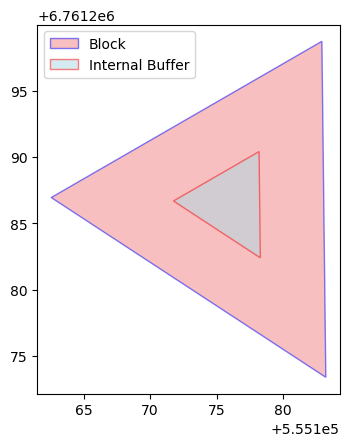

union_area
236.25977939624872
internal_buffer_area
233.77400919390394


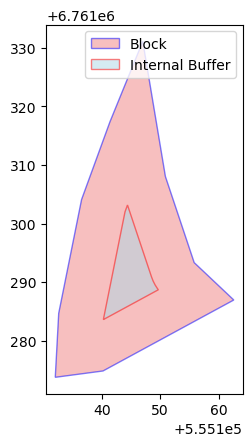

union_area
721.6514813095299
internal_buffer_area
721.6514813095299


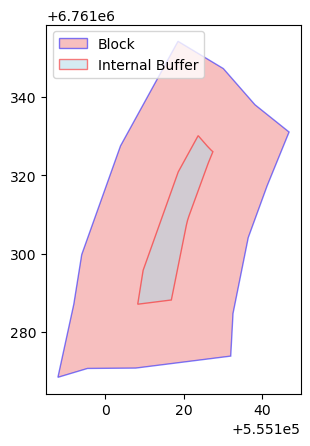

union_area
2721.2321374372395
internal_buffer_area
2687.703332268071


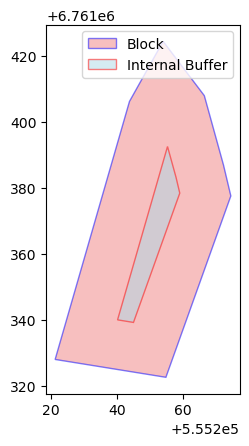

union_area
2813.05462430973
internal_buffer_area
2737.689953534987


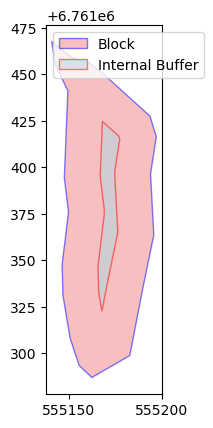

union_area
6194.994906749605
internal_buffer_area
6069.51177173247
0.8


In [19]:
#8 Two row blocks
# Compare the area of the buffer inside the block with a width equal to the radius of the largest circle fully contained within 
# the block minus a miniscule amount and the area of the union of the buffer and all the building footprints within the block. 
# If the two are equal, then the block is a two-row subdivision. If the latter is greater, it is not. 
# It may be a hybrid subdivision 
import json
from shapely.geometry import mapping, Polygon
def metric_8_two_row_blocks(blocks, buildings,row_epsilon):
    for block_id, block in blocks.iterrows():
        #print("fid")
        #print(block['fid'])
        block_area = block.area
        #optimal_point, max_radius = get_largest_inscribed_circle(block)
        target_area = block_area*(1.-row_epsilon)  # Set your target area
        internal_buffer = get_internal_buffer_with_target_area(block, target_area)
        #print(type(internal_buffer))
        buildings_for_union = unary_union(buildings.clip(block.geometry).geometry)
        result_union = internal_buffer.union(buildings_for_union)
        union_area = result_union.area
        internal_buffer_area = internal_buffer.area  
        internal_buffer = block.geometry.difference(internal_buffer)
        
        # Plotting
        fig, ax = plt.subplots()
        
        # Plot the block
        x, y = block.geometry.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='lightcoral', ec='blue', label='Block')
        #gpd.GeoSeries(block).to_file(f"blocks_tile_0_{block_id}_exterior.gpkg", driver="GPKG")
        geojson = mapping(block.geometry)
        with open(f'blocks_tile_17_{block_id}_exterior.geojson', 'w') as f:
            json.dump(geojson, f)
        # Plot the internal buffer
        
        if isinstance(internal_buffer, Polygon):
            # Handle single Polygon
            x2, y2 = internal_buffer.exterior.xy
            ax.fill(x2, y2, alpha=0.5, fc='lightblue', ec='red', label='Internal Buffer')
        elif isinstance(internal_buffer, MultiPolygon):
        # Handle MultiPolygon
            for polygon in internal_buffer.geoms:
                x2, y2 = polygon.exterior.xy
                ax.fill(x2, y2, alpha=0.5, fc='lightblue', ec='red')#, label='Internal Buffer')
    
        #gpd.GeoSeries(internal_buffer).to_file(f"internal_buffer_tile_0_{block_id}_exterior.geojson", driver="GPKG")
        geojson = mapping(internal_buffer)
        with open(f'internal_buffer_tile_17_{block_id}_exterior.geojson', 'w') as f:
            json.dump(geojson, f)
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.show()

        print("union_area")
        print(union_area)
        print("internal_buffer_area")
        print(internal_buffer_area)
        if union_area > internal_buffer_area:
            blocks.loc[block_id,'buildings_outside_buffer'] = True
        elif union_area <= internal_buffer_area:
            blocks.loc[block_id,'buildings_outside_buffer'] = False
    return blocks['buildings_outside_buffer'].mean()
print(metric_8_two_row_blocks(blocks,buildings,row_epsilon=0.1))


        

<Axes: >

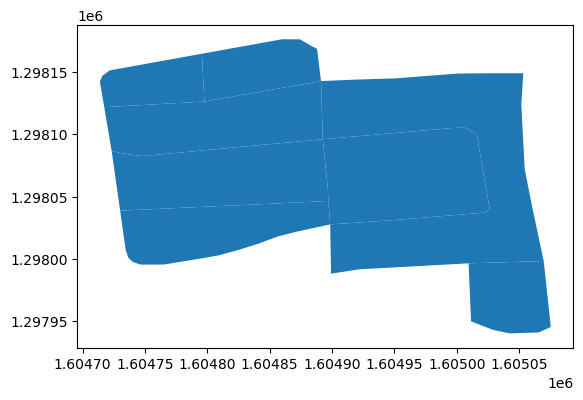

In [ ]:
blocks.plot()

In [ ]:
with open(f'buildings_17', 'w') as f:
            json.dump(mapping(buildings.geometry), f)

<Axes: >

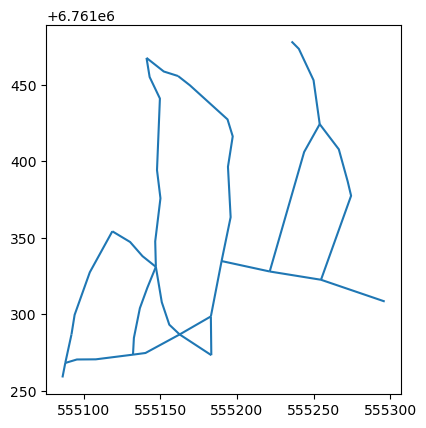

In [62]:
roads.plot()

In [68]:
#9 Tortuosity index

def metric_9_tortuosity_index(roads, intersections, angular_threshold=20, tortuosity_tolerance=0.5):
    
    inflection_points_gdf = get_inflection_points(roads, angular_threshold)
    combined_points = pd.concat([inflection_points_gdf, intersections], ignore_index=True)
    combined_points = combined_points.set_geometry('geometry')

    # Ensure CRS consistency
    combined_points.set_crs(roads.crs, inplace=True)

    # Create a graph to determine the order of points
    G = nx.Graph()

    # Add nodes to the graph for each point in the combined GeoDataFrame
    for idx, point in combined_points.iterrows():
        G.add_node(idx, geometry=point.geometry)

    # Add edges between each pair of points based on proximity along the road network
    for i in range(len(combined_points)):
        for j in range(i + 1, len(combined_points)):
            point_A = combined_points.iloc[i].geometry
            point_B = combined_points.iloc[j].geometry

            # Find the nearest points on the road network for A and B
            nearest_A = nearest_points(roads.unary_union, point_A)[0]
            nearest_B = nearest_points(roads.unary_union, point_B)[0]

            # Calculate the road network distance
            road_network_distance = roads.geometry.length.loc[
                roads.intersects(nearest_A.buffer(1e-6)) & roads.intersects(nearest_B.buffer(1e-6))
            ].min()

            # Handle NaN values
            if np.isnan(road_network_distance):
                road_network_distance = 1e6  # Arbitrary large number, adjust if necessary

            # Add the edge with the distance as weight
            G.add_edge(i, j, weight=road_network_distance)

    # Find the minimum spanning tree to order the points
    mst = nx.minimum_spanning_tree(G)

    # Get the ordered points by traversing the minimum spanning tree
    ordered_indices = list(nx.dfs_preorder_nodes(mst, source=0))  # Starting from the first point
    ordered_combined_points = combined_points.iloc[ordered_indices].reset_index(drop=True)

    # Initialize lists to store distances
    euclidean_distances = []
    road_network_distances = []
    indices_to_keep = []

    # Iterate through contiguous points
    for i in range(len(ordered_combined_points) - 1):
        point_A = ordered_combined_points.iloc[i].geometry
        point_B = ordered_combined_points.iloc[i + 1].geometry

        # Calculate the straight-line Euclidean distance
        euclidean_distance = point_A.distance(point_B)
        
        # Find the nearest points on the road network for A and B
        nearest_A = nearest_points(roads.unary_union, point_A)[0]
        nearest_B = nearest_points(roads.unary_union, point_B)[0]

        # Calculate the road network distance
        road_network_distance = roads.geometry.length.loc[
            roads.intersects(nearest_A.buffer(1e-6)) & roads.intersects(nearest_B.buffer(1e-6))
        ].min()
        if road_network_distance > tortuosity_tolerance:
            euclidean_distances.append(euclidean_distance)
            road_network_distances.append(road_network_distance)
            indices_to_keep.append(i)

    # Combine the results into a DataFrame
    distance_comparison = pd.DataFrame({
        'Point_A': ordered_combined_points.geometry[:-1].reset_index(drop=True).iloc[indices_to_keep],
        'Point_B': ordered_combined_points.geometry[1:].reset_index(drop=True).iloc[indices_to_keep],
        'Euclidean_Distance': euclidean_distances,
        'Road_Network_Distance': road_network_distances
    })
    m9 = (distance_comparison['Euclidean_Distance']/distance_comparison['Road_Network_Distance']).mean()
    return m9, combined_points


m9, combined_points = metric_9_tortuosity_index(roads, OSM_intersections, angular_threshold=30, tortuosity_tolerance=5)

print(m9)
#combined_points.plot()

/Users/sarangof/miniconda3/envs/subdivisions/lib/python3.12/site-packages/geopandas/array.py:1470: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as unknown (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


0.8992589715860823


In [47]:
#10 Average angle between road segments
def metric_10_average_angle_between_road_segments(intersections, roads):
    df_angles = calculate_sequential_angles(intersections, roads)
    intersection_angles_df = OSM_intersections[['osmid','street_count']].set_index('osmid').merge(df_angles.set_index('Intersection ID'),left_index=True,right_index=True,how='outer')

    # In 3-way intersections, include only the smallest angle in the tile average. 
    df_3_way = intersection_angles_df[(intersection_angles_df.street_count==3)]
    to_keep_3 = df_3_way.reset_index().loc[(df_3_way.reset_index().groupby(df_3_way.index)['Angle'].idxmin())].set_index('index')

    # In 4-way intersections, include only the two smallest angles in the tile average.
    df_4_way = intersection_angles_df[intersection_angles_df.street_count==4]
    to_keep_4 = df_4_way.groupby(df_4_way.index).apply(lambda x: x.nsmallest(2, 'Angle')).reset_index().set_index('level_0')
    to_keep_4.index.names = ['index']

    return pd.concat([to_keep_3,to_keep_4])['Angle'].median()
    

metric_10_average_angle_between_road_segments(OSM_intersections, roads)

69.12151774084255

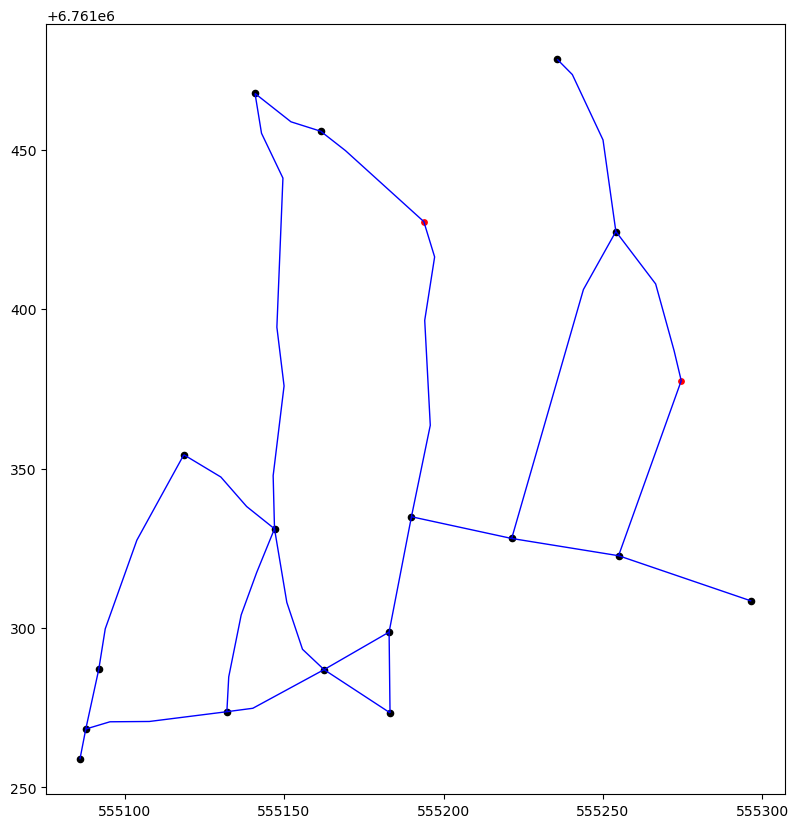

In [66]:
# SOME DRAWINGS

inflection_points_gdf = get_inflection_points(roads, threshold=30)
inflection_points_gdf = inflection_points_gdf.set_crs(utm_proj_rectangle)

# Plotting
ax = roads.plot(figsize=(10, 10), color='blue', linewidth=1)
OSM_intersections.to_crs(utm_proj_rectangle).plot(ax=ax, color='black', markersize=20)
inflection_points_gdf.plot(ax=ax, color='red', markersize=15)

# Optional: Show plot
plt.show()

In [ ]:
def draw_optimal_circle(block,optimal_point,max_radius):
    circle = optimal_point.buffer(max_radius)

    # Plot the block polygon
    fig, ax = plt.subplots()
    x, y = block.geometry.exterior.xy
    ax.fill(x, y, alpha=0.5, fc='lightblue', ec='blue')  # Draw the polygon

    # Plot the circle
    x, y = circle.exterior.xy
    ax.plot(x, y, color='red', linewidth=2)  # Draw the circle

    # Plot the optimal point (center of the circle)
    ax.plot(optimal_point.x, optimal_point.y, 'ro')  # Red point for the center

    # Set limits and show the plot
    #ax.set_xlim(-1, 5)
    #ax.set_ylim(-1, 4)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

optimal_point,max_radius = get_largest_inscribed_circle(blocks.iloc[0])
draw_optimal_circle(blocks.iloc[0],optimal_point,max_radius)